# Saving Matlab Struct's 4D image files to 3D

In [8]:
import os
import h5py
import numpy as np
import nibabel as nib
from typing import Dict, List, Optional, Any
import h5py
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

In [9]:
def export_hsr_mat_to_nifti(
    rootdirectory: str,
    save_folder_directory: str,
    num_channels_rq: int = 6,
    swap_xy: bool = False,         # MATLAB often stores volumes as (Y,X,Z); swap to (X,Y,Z)
    force_float32: bool = True
):
    """
    'rootdirectory' expects a full directory to the SampleISPY2Data folder that contains all 9 patients

    Walks `rootdirectory`, finds one .mat under each .../v*/scandata, reads HSR_DCE_struct/Data,
    splits channels correctly, flips 3D orientation to account for .mat column major vs .py row major, and saves NIfTI files.

    Assumptions / heuristics:
      - .mat file is 4D: spatial-spatial-spatial-channel.
      - Channel axis is the one with a small size (usually == num_channels_rq or <= 12).
      - Slice axis is the smallest of the three spatial dims.

    Returns manifest: for debugging. Actual NIfTI file saving into save_folder_directory is done within the function.
      manifest: list of dicts with {'patient_idx','channel','path','shape','affine_diag'}
    """
    os.makedirs(save_folder_directory, exist_ok=True)
    manifest = []

    # helper: try to read a 1D array from an h5 path (if exists)
    def _get1d(ds_parent, key):
        try:
            if key in ds_parent:
                arr = np.array(ds_parent[key]).squeeze()
                return np.asarray(arr, dtype=float)
        except Exception:
            pass
        return None

    # helper: build an affine if voxel sizes are available
    def _build_affine(hsr_group, vol_xyz):
        # defaults
        sx = sy = sz = 1.0

        # Try common fields
        px = _get1d(hsr_group, "PixelSpacing")       # [row, col] or [dy, dx]
        st = _get1d(hsr_group, "SliceThickness")     # scalar
        sbs = _get1d(hsr_group, "SpacingBetweenSlices")  # scalar
        vox = _get1d(hsr_group, "voxel_size") or _get1d(hsr_group, "voxelSize")  # [dx,dy,dz] sometimes

        if vox is not None and vox.size >= 3:
            sx, sy, sz = float(vox[0]), float(vox[1]), float(vox[2])
        else:
            if px is not None and px.size >= 2:
                # PixelSpacing is usually [row_spacing_mm, col_spacing_mm] = [dy, dx]
                sy = float(px[0])  # dy  (maps to Y)
                sx = float(px[1])  # dx  (maps to X)
            if sbs is not None and np.isfinite(sbs).size != 0:
                sz = float(np.atleast_1d(sbs)[0])
            elif st is not None and np.isfinite(st).size != 0:
                sz = float(np.atleast_1d(st)[0])

        aff = np.eye(4, dtype=float)
        aff[0, 0] = sx
        aff[1, 1] = sy
        aff[2, 2] = sz
        return aff

    # iterate folders like your original function
    folder_list = [os.path.join(rootdirectory, f) for f in os.listdir(rootdirectory)
                   if os.path.isdir(os.path.join(rootdirectory, f))]
    print(f"Found {len(folder_list)} folders under {rootdirectory}")

    patient_counter = 1
    for folder in folder_list:
        subfolders = [os.path.join(folder, sf) for sf in os.listdir(folder)
                      if os.path.isdir(os.path.join(folder, sf))]
        for sub in subfolders:
            scandata_path = os.path.join(sub, "scandata")
            if not os.path.isdir(scandata_path):
                #patient_counter += 1
                continue

            mat_files = [os.path.join(scandata_path, f) for f in os.listdir(scandata_path)
                         if f.endswith(".mat")]
            if len(mat_files) != 1:
                # 0 or >1 files: skip but advance counter to keep numbering stable
                if len(mat_files) == 0:
                    print(f"[skip] No .mat in {scandata_path}")
                else:
                    print(f"[skip] Multiple .mat files in {scandata_path}")
                continue

            mat_file = mat_files[0]
            print(f"\nOpening {mat_file}")
            with h5py.File(mat_file, "r") as f:
                if "HSR_DCE_struct" not in f:
                    print(f"[warn] 'HSR_DCE_struct' not found. Keys: {list(f.keys())}")

                    continue

                hsr = f["HSR_DCE_struct"]
                if "Data" not in hsr:
                    print(f"[warn] 'Data' not found in HSR_DCE_struct. Fields: {list(hsr.keys())}")

                    continue

                # Matlab to Python image conversion (permute axes back to MATLAB order)
                raw = hsr["Data"]               # h5py dataset, shape e.g. (8, 26, 339, 339)
                data = np.array(raw)            # now a NumPy array with that shape
                data = data.transpose(tuple(range(data.ndim-1, -1, -1)))  # reverse axes
                print("Data shape (MATLAB order):", data.shape)  # -> (339, 339, 26, 8)
                print(f"  Data shape corrected {data.shape}, dtype {data.dtype}")

                if data.ndim != 4:
                    print(f"[warn] Expected 4D array, got {data.ndim}D. Skipping.")

                    continue

                # ---- detect channel axis
                # prefer axis whose size == num_channels_rq; else any axis with size <= 12
                candidates = [ax for ax, s in enumerate(data.shape) if s == num_channels_rq]
                if not candidates:
                    candidates = [ax for ax, s in enumerate(data.shape) if s <= 12]
                chan_axis = candidates[0] if candidates else 3
                n_chan = data.shape[chan_axis]
                print(f"  Using channel axis {chan_axis} (size={n_chan})")

                # how many channels to output
                outC = min(n_chan, num_channels_rq)
                if n_chan < num_channels_rq:
                    print(f"  Only {n_chan} channels present; duplicating last to reach {num_channels_rq}")

                # loop channels (duplicating last if needed)
                for ch in range(num_channels_rq):
                    ch_idx = min(ch, n_chan - 1)
                    vol = np.take(data, ch_idx, axis=chan_axis)  # -> 3D

                    if vol.ndim != 3:
                        print(f"  [warn] After channel take, got {vol.ndim}D; skipping channel {ch}")
                        continue

                    # ---- set Z as the smallest spatial dimension (slice count)
                    z_axis = int(np.argmin(vol.shape))
                    vol_z_last = np.moveaxis(vol, z_axis, 2)  # (..., Z)
                    # optional XY swap (MATLAB (Y,X,Z) → (X,Y,Z))
                    vol_xyz = vol_z_last.transpose(1, 0, 2) if swap_xy else vol_z_last

                    if force_float32 and vol_xyz.dtype != np.float32:
                        vol_xyz = vol_xyz.astype(np.float32, copy=False)

                    # ---- affine
                    affine = _build_affine(hsr, vol_xyz)

                    # ---- save NIfTI
                    nii = nib.Nifti1Image(vol_xyz, affine)
                    # standardize to RAS+ (just for consistent display across tools)
                    nii = nib.as_closest_canonical(nii)

                    save_name = f"Breast_{patient_counter:04d}_{ch:04d}.nii.gz"
                    save_path = os.path.join(save_folder_directory, save_name)
                    nib.save(nii, save_path)

                    manifest.append({
                        "patient_idx": patient_counter,
                        "channel": ch,
                        "path": save_path,
                        "shape": tuple(vol_xyz.shape),
                        "affine_diag": (affine[0, 0], affine[1, 1], affine[2, 2])
                    })
                    print(f"  Saved {save_name}  shape={vol_xyz.shape}  vox={manifest[-1]['affine_diag']}")
                

                patient_counter += 1

    return manifest


In [10]:
rootdirectory = r"D:\OneDrive - UW\QBI lab\BCNAT\Lloyd735\SampleISPY2Data"
matdata = export_hsr_mat_to_nifti(rootdirectory, save_folder_directory=r"D:\OneDrive - UW\QBI lab\Testing Space", swap_xy=False)

Found 11 folders under D:\OneDrive - UW\QBI lab\BCNAT\Lloyd735\SampleISPY2Data

Opening D:\OneDrive - UW\QBI lab\BCNAT\Lloyd735\SampleISPY2Data\ISPY2_102212\v0\scandata\ISPY2_102212_v0_HSR_DCE_InterpAlign.mat
Data shape (MATLAB order): (339, 339, 26, 8)
  Data shape corrected (339, 339, 26, 8), dtype float64
  Using channel axis 3 (size=8)
  Saved Breast_0001_0000.nii.gz  shape=(339, 339, 26)  vox=(np.float64(1.0), np.float64(1.0), np.float64(1.0))
  Saved Breast_0001_0001.nii.gz  shape=(339, 339, 26)  vox=(np.float64(1.0), np.float64(1.0), np.float64(1.0))
  Saved Breast_0001_0002.nii.gz  shape=(339, 339, 26)  vox=(np.float64(1.0), np.float64(1.0), np.float64(1.0))
  Saved Breast_0001_0003.nii.gz  shape=(339, 339, 26)  vox=(np.float64(1.0), np.float64(1.0), np.float64(1.0))
  Saved Breast_0001_0004.nii.gz  shape=(339, 339, 26)  vox=(np.float64(1.0), np.float64(1.0), np.float64(1.0))
  Saved Breast_0001_0005.nii.gz  shape=(339, 339, 26)  vox=(np.float64(1.0), np.float64(1.0), np.float6

# Extracting ground truth tumor masks: _fcm, _final, _nonec

In [11]:
def extract_and_save_ispy2_rois(rootdirectory: str, savefolder: str) -> List[Dict[str, Any]]:
    """
    Scan `rootdirectory` for folders whose names start with 'ISPY2_'.
    Treat the first such folder (sorted by name) as patient 0001, the next as 0002, etc.
    For each patient:
      - Look under {ISPY2_xxx}/para/** for .mat files.
      - From the file containing 'BreastFGTROI' in its name, read:
            HSR_DCE_ROI_struct -> breast -> breast_mask
      - From the file containing 'BreastTumorROI' in its name, read:
            tumor -> tumor_ROI_fcm, tumor_ROI_final, tumor_ROI_nonec
      - Apply MATLAB (column-major) → NumPy (row-major) axis reversal per request:
            arr = arr.transpose(tuple(range(arr.ndim - 1, -1, -1)))
      - Save arrays to `savefolder` with names:
            Breast_000n_breast_mask.npy
            Breast_000n_tumor_ROI_fcm.npy
            Breast_000n_tumor_ROI_final.npy
            Breast_000n_tumor_ROI_nonec.npy

    Returns
    -------
    summary : list of dict
        Per-patient summary with saved paths and any non-fatal errors.
    """
    os.makedirs(savefolder, exist_ok=True)

    # Gather and sort patient folders deterministically
    patient_dirs = sorted(
        [e.path for e in os.scandir(rootdirectory) if e.is_dir() and e.name.startswith("ISPY2_")]
    )

    summary: List[Dict[str, Any]] = []

    for idx, ispy_path in enumerate(patient_dirs, start=1):
        patient_id = f"{idx:04d}"

        rec: Dict[str, Any] = {
            "patient_dir": ispy_path,
            "patient_id": patient_id,
            "BreastFGTROI_path": None,
            "BreastTumorROI_path": None,
            "saved": {
                "breast_mask": None,
                "tumor_ROI_fcm": None,
                "tumor_ROI_final": None,
                "tumor_ROI_nonec": None,
            },
            "errors": [],
        }

        # Locate 'para' and .mat files
        para_dir = os.path.join(ispy_path, "v0/para")
        if not os.path.isdir(para_dir):
            rec["errors"].append("No 'para' folder found")
            summary.append(rec)
            continue

        mat_paths: List[str] = []
        for r, _, files in os.walk(para_dir):
            for fn in files:
                if fn.lower().endswith(".mat"):
                    mat_paths.append(os.path.join(r, fn))

        breast_fgt_roi_path = _first_path_with(mat_paths, "BreastFGTROI")
        breast_tumor_roi_path = _first_path_with(mat_paths, "BreastTumorROI")

        rec["BreastFGTROI_path"] = breast_fgt_roi_path
        rec["BreastTumorROI_path"] = breast_tumor_roi_path

        # --- Read BreastFGTROI -> breast_mask ---
        breast_mask_arr: Optional[np.ndarray] = None
        if breast_fgt_roi_path:
            try:
                with h5py.File(breast_fgt_roi_path, "r") as f:
                    hs = _get_group_or_deref(f, f.get("HSR_DCE_ROI_struct"))
                    if hs is None:
                        raise KeyError("HSR_DCE_ROI_struct not found")
                    breast = _get_group_or_deref(f, _get_child(hs, "breast"))
                    if breast is None:
                        raise KeyError("breast struct not found under HSR_DCE_ROI_struct")
                    mask_node = _get_child(breast, "breast_mask")
                    breast_mask_arr = _read_mat_array(f, mask_node)
                    if breast_mask_arr is None:
                        raise KeyError("breast_mask dataset not found or unreadable")
                    if breast_mask_arr.ndim >= 2:
                        breast_mask_arr = _reverse_axes(breast_mask_arr)
            except Exception as e:
                rec["errors"].append(f"BreastFGTROI parse error: {e}")
                breast_mask_arr = None
        else:
            rec["errors"].append("BreastFGTROI .mat not found")

        # --- Read BreastTumorROI -> tumor_ROI_* ---
        tumor_ROI_fcm = tumor_ROI_final = tumor_ROI_nonec = None
        if breast_tumor_roi_path:
            try:
                with h5py.File(breast_tumor_roi_path, "r") as f:
                    tumor = _get_group_or_deref(f, f.get("tumor"))
                    if tumor is None:
                        # Fallback: try common top-level structs
                        for cand in ("HSR_DCE_ROI_struct", "HSR_DCE_struct", "Data"):
                            g = _get_group_or_deref(f, f.get(cand))
                            if g is not None:
                                tumor = _get_group_or_deref(f, _get_child(g, "tumor"))
                                if tumor is not None:
                                    break
                    if tumor is None:
                        raise KeyError("tumor struct not found")

                    for key in ("tumor_ROI_fcm", "tumor_ROI_final", "tumor_ROI_nonec"):
                        arr = _read_mat_array(f, _get_child(tumor, key))
                        if arr is not None and arr.ndim >= 2:
                            arr = _reverse_axes(arr)
                        if key == "tumor_ROI_fcm":
                            tumor_ROI_fcm = arr
                        elif key == "tumor_ROI_final":
                            tumor_ROI_final = arr
                        elif key == "tumor_ROI_nonec":
                            tumor_ROI_nonec = arr

            except Exception as e:
                rec["errors"].append(f"BreastTumorROI parse error: {e}")
        else:
            rec["errors"].append("BreastTumorROI .mat not found")

        # --- Save with requested names ---
        # Breast_000n_breast_mask.npy, Breast_000n_tumor_ROI_fcm.npy, etc.
        try:
            if breast_mask_arr is not None:
                path = os.path.join(savefolder, f"Breast_{patient_id}_breast_mask.nii.gz")
                save_as_nii(breast_mask_arr, path)
                rec["saved"]["breast_mask"] = path
        except Exception as e:
            rec["errors"].append(f"Save breast_mask failed: {e}")

        try:
            if tumor_ROI_fcm is not None:
                path = os.path.join(savefolder, f"Breast_{patient_id}_tumor_ROI_fcm.nii.gz")
                save_as_nii(tumor_ROI_fcm, path)
                rec["saved"]["tumor_ROI_fcm"] = path
        except Exception as e:
            rec["errors"].append(f"Save tumor_ROI_fcm failed: {e}")

        try:
            if tumor_ROI_final is not None:
                path = os.path.join(savefolder, f"Breast_{patient_id}_tumor_ROI_final.nii.gz")
                save_as_nii(tumor_ROI_final, path)
                rec["saved"]["tumor_ROI_final"] = path
        except Exception as e:
            rec["errors"].append(f"Save tumor_ROI_final failed: {e}")

        try:
            if tumor_ROI_nonec is not None:
                path = os.path.join(savefolder, f"Breast_{patient_id}_tumor_ROI_nonec.nii.gz")
                save_as_nii(tumor_ROI_nonec, path)
                rec["saved"]["tumor_ROI_nonec"] = path
        except Exception as e:
            rec["errors"].append(f"Save tumor_ROI_nonec failed: {e}")

        summary.append(rec)

    return summary


# -------------------------
# Helper utilities (v7.3)
# -------------------------

def _first_path_with(paths: List[str], needle: str) -> Optional[str]:
    """Return the first path whose basename contains `needle` (case sensitive)."""
    for p in sorted(paths):
        if needle in os.path.basename(p):
            return p
    return None


def _reverse_axes(arr: np.ndarray) -> np.ndarray:
    """
    Reverse axes to account for MATLAB (column-major) vs Python (row-major)
    orientation differences as requested:
        data = data.transpose(tuple(range(data.ndim - 1, -1, -1)))
    """
    return arr.transpose(tuple(range(arr.ndim - 1, -1, -1)))


def _is_ref_dataset(dset: h5py.Dataset) -> bool:
    """Heuristic: dataset stores object references (common with MATLAB structs/cells)."""
    try:
        return dset.dtype == h5py.ref_dtype or getattr(dset.dtype, "kind", "") == "O"
    except Exception:
        return False


def _resolve_ref_once(f: h5py.File, node: Any) -> Any:
    """
    If `node` is a dataset of object references, dereference one level.
    Otherwise return `node` unchanged.
    """
    if isinstance(node, h5py.Dataset) and _is_ref_dataset(node):
        ref_obj = node[()]
        try:
            ref = np.array(ref_obj).flat[0]
        except Exception:
            ref = ref_obj
        try:
            return f[ref]
        except Exception:
            return node
    return node


def _get_group_or_deref(f: h5py.File, node: Any) -> Optional[h5py.Group]:
    """Interpret `node` as a Group, resolving a single ref if needed."""
    if node is None:
        return None
    node = _resolve_ref_once(f, node)
    if isinstance(node, h5py.Group):
        return node
    node = _resolve_ref_once(f, node)
    return node if isinstance(node, h5py.Group) else None


def _get_child(group: h5py.Group, name: str) -> Optional[Any]:
    """Return child by name if present, else None."""
    try:
        return group.get(name, default=None)
    except Exception:
        return None


def _read_mat_array(f: h5py.File, node: Any) -> Optional[np.ndarray]:
    """
    Read a MATLAB v7.3 array from `node`:
      - If `node` is a dataset: return np.array(node[()])
      - If `node` is a dataset of refs: deref once and read
      - If `node` is a group, try common dataset names inside ('value', 'data', etc.)
    Returns None on failure.
    """
    if node is None:
        return None

    node = _resolve_ref_once(f, node)

    if isinstance(node, h5py.Dataset) and not _is_ref_dataset(node):
        try:
            return np.array(node[()])
        except Exception:
            return None

    if isinstance(node, h5py.Dataset) and _is_ref_dataset(node):
        node = _resolve_ref_once(f, node)
        if isinstance(node, h5py.Dataset):
            try:
                return np.array(node[()])
            except Exception:
                return None

    if isinstance(node, h5py.Group):
        for k in ("value", "data", "Data", "array", "values"):
            if k in node and isinstance(node[k], h5py.Dataset):
                try:
                    return np.array(node[k][()])
                except Exception:
                    pass
        for k in node.keys():
            if isinstance(node[k], h5py.Dataset):
                try:
                    return np.array(node[k][()])
                except Exception:
                    pass

    return None

def save_as_nii(arr: np.ndarray, outpath: str):
    """
    Save a numpy array as a NIfTI .nii.gz file.
    Uses identity affine by default (no spatial transform).
    """
    # Ensure float32 for compatibility and lower size
    arr = arr.astype(np.float32)

    # Create a NIfTI image with identity affine
    nii_img = nib.Nifti1Image(arr, affine=np.eye(4))

    # Save compressed
    nib.save(nii_img, outpath)

In [12]:
rootdirectory = r"D:\OneDrive - UW\QBI lab\BCNAT\Lloyd735\SampleISPY2Data"
savefolder    = r"D:\OneDrive - UW\QBI lab\Testing Space"
extract_and_save_ispy2_rois(rootdirectory, savefolder)

[{'patient_dir': 'D:\\OneDrive - UW\\QBI lab\\BCNAT\\Lloyd735\\SampleISPY2Data\\ISPY2_102212',
  'patient_id': '0001',
  'BreastFGTROI_path': 'D:\\OneDrive - UW\\QBI lab\\BCNAT\\Lloyd735\\SampleISPY2Data\\ISPY2_102212\\v0/para\\ISPY2_102212_v0_HSR_DCE_BreastFGTROI_InterpAlign.mat',
  'BreastTumorROI_path': 'D:\\OneDrive - UW\\QBI lab\\BCNAT\\Lloyd735\\SampleISPY2Data\\ISPY2_102212\\v0/para\\ISPY2_102212_v0_HSR_DCE_BreastTumorROI_InterpAlign.mat',
  'saved': {'breast_mask': 'D:\\OneDrive - UW\\QBI lab\\Testing Space\\Breast_0001_breast_mask.nii.gz',
   'tumor_ROI_fcm': 'D:\\OneDrive - UW\\QBI lab\\Testing Space\\Breast_0001_tumor_ROI_fcm.nii.gz',
   'tumor_ROI_final': 'D:\\OneDrive - UW\\QBI lab\\Testing Space\\Breast_0001_tumor_ROI_final.nii.gz',
   'tumor_ROI_nonec': 'D:\\OneDrive - UW\\QBI lab\\Testing Space\\Breast_0001_tumor_ROI_nonec.nii.gz'},
  'errors': []},
 {'patient_dir': 'D:\\OneDrive - UW\\QBI lab\\BCNAT\\Lloyd735\\SampleISPY2Data\\ISPY2_104268',
  'patient_id': '0002',
  '

# Developing custom cropping - island removal

In [13]:
def remove_islands_from_2d_mask(mask2d: np.ndarray,
                               abs_min_area: int = 500,
                               rel_min_area: float = 0.05, plot = False):
    """
    Detect and visualize main components on left and right halves,
    and show only original + combined outputs.
    """
    mask2d = mask2d.astype(bool)
    H, W = mask2d.shape
    x_mid = W // 2

    def _largest_cc_2d(mask2d: np.ndarray,
                       abs_min_area: int = 500,
                       rel_min_area: float = 0.05) -> np.ndarray:
        mask2d = mask2d.astype(bool)
        if not mask2d.any():
            return np.zeros_like(mask2d, bool)

        structure = np.ones((3, 3), dtype=bool)  # 8-connectivity
        labels, n = ndi.label(mask2d, structure=structure)
        if n == 0:
            return np.zeros_like(mask2d, bool)

        areas = np.bincount(labels.ravel())
        areas[0] = 0
        main_lab = int(np.argmax(areas))
        main_area = int(areas[main_lab])

        if main_area < max(abs_min_area, int(rel_min_area * (main_area + 1e-9))):
            return np.zeros_like(mask2d, bool)

        return labels == main_lab

    # Split into halves
    left_mask = mask2d[:, :x_mid]
    right_mask = mask2d[:, x_mid:]

    # Compute largest CC for each half
    left_main = _largest_cc_2d(left_mask, abs_min_area, rel_min_area)
    right_main = _largest_cc_2d(right_mask, abs_min_area, rel_min_area)

    # Combine into full mask
    combined = np.zeros_like(mask2d, bool)
    combined[:, :x_mid] = left_main
    combined[:, x_mid:] = right_main

    # Visualization
    if plot is True:
        plt.figure(figsize=(10,4), facecolor='black')

        plt.subplot(1, 2, 1)
        plt.imshow(mask2d, cmap='gray', vmin=0, vmax=1)
        plt.title('Original mask', color='white')
        plt.axis('off')
        plt.gca().set_facecolor('black')

        plt.subplot(1, 2, 2)
        plt.imshow(combined, cmap='gray', vmin=0, vmax=1)
        plt.title('Islands Removed', color='white')
        plt.axis('off')
        plt.gca().set_facecolor('black')

        plt.tight_layout()
        plt.show()

    return combined


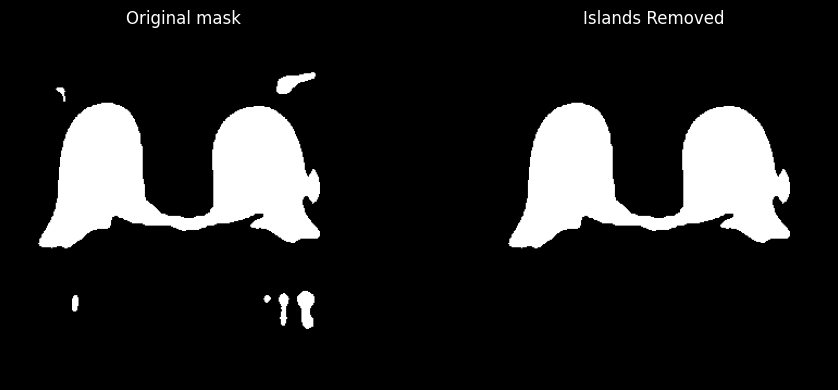

In [15]:
# this is for testing the island removal function. 
# not going to actually loop through the entire dataset: just testing a sample slice is all.

FGT_mask_path = r"D:\OneDrive - UW\QBI lab\Testing Space\Breast_0006_breast_mask.nii.gz"
mask3d = nib.load(FGT_mask_path).get_fdata().astype(bool)

z = mask3d.shape[2] // 2  # middle slice
mask2d = mask3d[:, :, z]

combined = remove_islands_from_2d_mask(mask2d, plot = True)


# Creating custom mask from island_removed

In [16]:
# in that column of 2D bool array, find the y value of a nonzero value with the min y value. save that into a y array. save the x value into xarray.
# if there are no nonzero values in that column, save y = None and iterate through all x values x in range(n_x). 
# then we are going to take care of the points with y = None with the following logic:
# there are three possible cases. 
# if you are at the left edge of the image, meaning all points before the first ever nonzero point emerged,
# then arbitraily decide the y values of all points before that first nonzero value using y=x equation. 
# for example, if the first nonzero value was found at x=5, y=5, x=4 would be given y=4, x=3, y=3, and so on.
# if you are at the right edge of image, then use y=-x.
# if you are not at the right or left edge, then draw a straight line to connect the holes and approximate the yvalues. make sure approximated y values are integers.
# in the future, implement polynomial crop: select n landmarks and fit a y=-ax^2 that has minimum distance to the landmarks and does not include any bool=True in FGT mask

def create_custom_mask(cleaned_mask2d: np.ndarray, plot=False):
    """
    Build a per-column y-curve (bottom boundary) and black out all pixels BELOW that curve.
    """
    m = cleaned_mask2d.astype(bool)
    H, W = m.shape
    x = np.arange(W)

    # --- 1) Bottommost True per column ---
    y = np.full(W, np.nan, dtype=float)
    for xi in range(W):
        ys = np.flatnonzero(m[:, xi])
        if ys.size:
            y[xi] = float(ys.max())  # bottommost (smallest y)

    if np.isnan(y).all():
        return np.zeros_like(m, bool)

    # --- 2) Fill edges (final, screen-correct version) ---
    known = np.where(~np.isnan(y))[0]
    first_x, last_x = known[0], known[-1]
    first_y, last_y = y[first_x], y[last_x]

    # Left edge: screen slope y = +x → NumPy slope = +1
    if first_x > 0:
        left_x = np.arange(0, first_x)
        y[left_x] = first_y + (first_x - left_x)   # add so it rises visually to the left

    # Right edge: screen slope y = -x → NumPy slope = +1
    if last_x < W - 1:
        right_x = np.arange(last_x + 1, W)
        y[right_x] = last_y + (right_x - last_x)

    # --- 3) Interpolate missing values ---
    missing = np.isnan(y)
    if missing.any():
        y[missing] = np.interp(x[missing], x[~missing], y[~missing])

    # --- 4) Round and clip to bounds ---
    y_curve = np.rint(y).astype(int)
    y_curve = np.clip(y_curve, 0, H - 1)

    # --- 5) Create mask: black below line, white above line ---
    custom_mask = np.zeros((H, W), dtype=bool)
    for xi in range(W):
        custom_mask[:y_curve[xi] + 1, xi] = True  # keep ABOVE the line

    if plot:
        plt.figure(figsize=(6, 6), facecolor="black")
        plt.imshow(custom_mask, cmap="gray", vmin=0, vmax=1)
        plt.title("Polynomial mask (blackout below)", color="white")
        plt.axis("off")
        plt.gca().set_facecolor("black")
        plt.show()

    return custom_mask



def _plot_poly_mask(orig: np.ndarray, custom_mask: np.ndarray, title: str = ''):
    plt.figure(figsize=(10, 4), facecolor='black')

    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(orig.astype(int), cmap='gray', vmin=0, vmax=1)
    ax1.set_title('Original mask', color='white')
    ax1.axis('off')
    ax1.set_facecolor('black')

    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(custom_mask.astype(int), cmap='gray', vmin=0, vmax=1)  # pure black/white
    ax2.set_title(title, color='white')
    ax2.axis('off')
    ax2.set_facecolor('black')

    plt.tight_layout()
    plt.show()


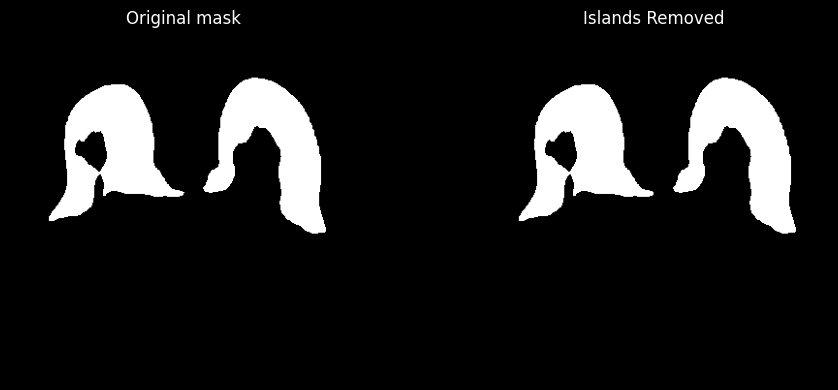

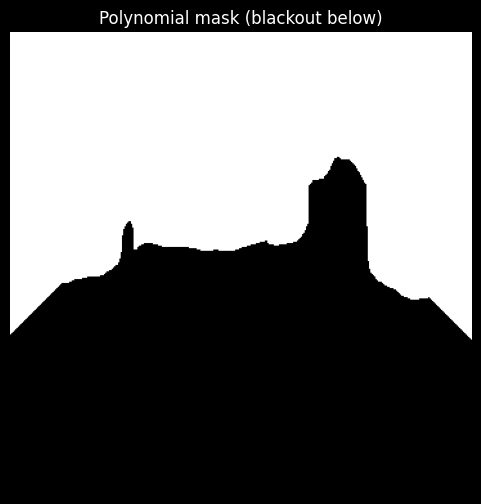

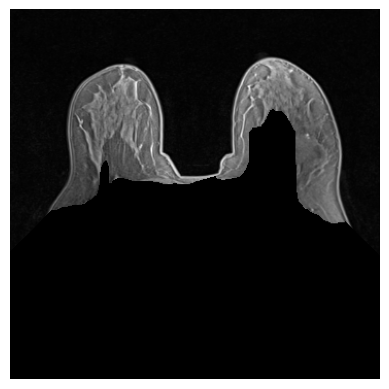

In [17]:
# this cell is testing the custom cropping mask by visualizing an example

# Load mask file
nii_path = r"D:\OneDrive - UW\QBI lab\Testing Space\Breast_0002_breast_mask.nii.gz"
mask3d = nib.load(nii_path).get_fdata().astype(bool)

# Pick a single 2D slice
z = mask3d.shape[2] // 2  # middle slice
mask2d = mask3d[:, :, z]
cleaned_mask = remove_islands_from_2d_mask(mask2d, plot=True)
custom_mask = create_custom_mask(cleaned_mask, plot=True)

img_path = r"D:\OneDrive - UW\QBI lab\Testing Space\Breast_0002_0000.nii.gz"
img_data = nib.load(img_path).get_fdata()

masked_img = img_data.copy()
masked_img[~custom_mask] = 0  # zero out background
z = masked_img.shape[2] // 2   # middle slice

# View
import matplotlib.pyplot as plt
plt.imshow(masked_img[:, :, z], cmap='gray')
plt.axis('off')
plt.show()




# Implementing & saving custom cropped images

In [19]:
def custom_crop_images(calldirectory, savedirectory, num_patients, num_channels=6):
    for patient in range(1, num_patients + 1):
        orig_FGT_mask = nib.load(f"{calldirectory}/Breast_{patient:04d}_breast_mask.nii.gz").get_fdata()  # this is 3D
        mask_list = []  # collect all 2D masks
        for z in range(orig_FGT_mask.shape[2]):
            mask2d = orig_FGT_mask[:, :, z]
            mask2d_cleaned = remove_islands_from_2d_mask(mask2d, plot=False)
            custom_mask_2d = create_custom_mask(mask2d_cleaned, plot=False)
            mask_list.append(custom_mask_2d)


        custom_mask_3d = np.stack(mask_list, axis=-1)

        for channel in range(num_channels):
            orig_img = nib.load(f"{calldirectory}/Breast_{patient:04d}_{channel:04d}.nii.gz").get_fdata()
            orig_img[~custom_mask_3d] = 0

            nii_img = nib.Nifti1Image(orig_img, affine=np.eye(4))
            outpath = os.path.join(savedirectory, f"Breast_{patient:04d}_{channel:04d}.nii.gz")
            nib.save(nii_img, outpath)


In [20]:
# this cell will save cropped images, that will be directly used for inference.
# warning: if the savedirectory is identical to calldirectory, running this cell will overwrite the original images "Breast_000x_000x.nii.gz" with cropped versions

custom_crop_images(r"D:\OneDrive - UW\QBI lab\Testing Space", 
                   r"D:\OneDrive - UW\QBI lab\Testing Space\Cropped original",
                   num_patients=9)

# Making dataset.json (only need to run inference)

In [7]:

#    Copyright 2020 Division of Medical Image Computing, German Cancer Research Center (DKFZ), Heidelberg, Germany
#
#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at
#
#        http://www.apache.org/licenses/LICENSE-2.0
#
#    Unless required by applicable law or agreed to in writing, software
#    distributed under the License is distributed on an "AS IS" BASIS,
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#    See the License for the specific language governing permissions and
#    limitations under the License.


from typing import Tuple
import numpy as np
from batchgenerators.utilities.file_and_folder_operations import *


def get_identifiers_from_splitted_files(folder: str):
    uniques = np.unique([i[:-12] for i in subfiles(folder, suffix='.nii.gz', join=False)])
    return uniques


def generate_dataset_json(output_file: str, imagesTr_dir: str, imagesTs_dir: str, modalities: Tuple,
                          labels: dict, dataset_name: str, sort_keys=True, license: str = "hands off!", dataset_description: str = "",
                          dataset_reference="", dataset_release='0.0'):
    """
    :param output_file: This needs to be the full path to the dataset.json you intend to write, so
    output_file='DATASET_PATH/dataset.json' where the folder DATASET_PATH points to is the one with the
    imagesTr and labelsTr subfolders
    :param imagesTr_dir: path to the imagesTr folder of that dataset
    :param imagesTs_dir: path to the imagesTs folder of that dataset. Can be None
    :param modalities: tuple of strings with modality names. must be in the same order as the images (first entry
    corresponds to _0000.nii.gz, etc). Example: ('T1', 'T2', 'FLAIR').
    :param labels: dict with int->str (key->value) mapping the label IDs to label names. Note that 0 is always
    supposed to be background! Example: {0: 'background', 1: 'edema', 2: 'enhancing tumor'}
    :param dataset_name: The name of the dataset. Can be anything you want
    :param sort_keys: In order to sort or not, the keys in dataset.json
    :param license:
    :param dataset_description:
    :param dataset_reference: website of the dataset, if available
    :param dataset_release:
    :return:
    """
    train_identifiers = get_identifiers_from_splitted_files(imagesTr_dir)

    if imagesTs_dir is not None:
        test_identifiers = get_identifiers_from_splitted_files(imagesTs_dir)
    else:
        test_identifiers = []

    json_dict = {}
    json_dict['name'] = dataset_name
    json_dict['description'] = dataset_description
    json_dict['tensorImageSize'] = "3D"
    json_dict['reference'] = dataset_reference
    json_dict['licence'] = license
    json_dict['release'] = dataset_release
    json_dict['modality'] = {str(i): modalities[i] for i in range(len(modalities))}
    json_dict['labels'] = {str(i): labels[i] for i in labels.keys()}

    json_dict['numTraining'] = len(train_identifiers)
    json_dict['numTest'] = len(test_identifiers)
    json_dict['training'] = [
        {'image': "./imagesTr/%s.nii.gz" % i, "label": "./labelsTr/%s.nii.gz" % i} for i
        in
        train_identifiers]
    json_dict['test'] = ["./imagesTs/%s.nii.gz" % i for i in test_identifiers]

    if not output_file.endswith("dataset.json"):
        print("WARNING: output file name is not dataset.json! This may be intentional or not. You decide. "
              "Proceeding anyways...")
    save_json(json_dict, os.path.join(output_file), sort_keys=sort_keys)



generate_dataset_json(output_file = r"D:\OneDrive - UW\QBI lab\BCNAT\Lloyd735\Janse Segmentation\nnUNet_raw_data_base\nnUNet_raw_data\Task789_LABC\dataset.json"
                      , imagesTr_dir=r"D:\OneDrive - UW\QBI lab\BCNAT\Lloyd735\Janse Segmentation\nnUNet_raw_data_base\nnUNet_raw_data\Task789_LABC\imagesTr"
                      , imagesTs_dir=r"D:\OneDrive - UW\QBI lab\BCNAT\Lloyd735\Janse Segmentation\nnUNet_raw_data_base\nnUNet_raw_data\Task789_LABC\imagesTs"
                      , modalities = ('T0', 'T1', 'T2','T3','T4','T5')
                      ,labels={0: 'background'}, dataset_name= "LABC", sort_keys=True, license = "hands off!", 
                      dataset_description = "Janse LABC model inference with ISPY2 data. first 6 channels.",
                          dataset_reference="Janse Paper", dataset_release='0.0')